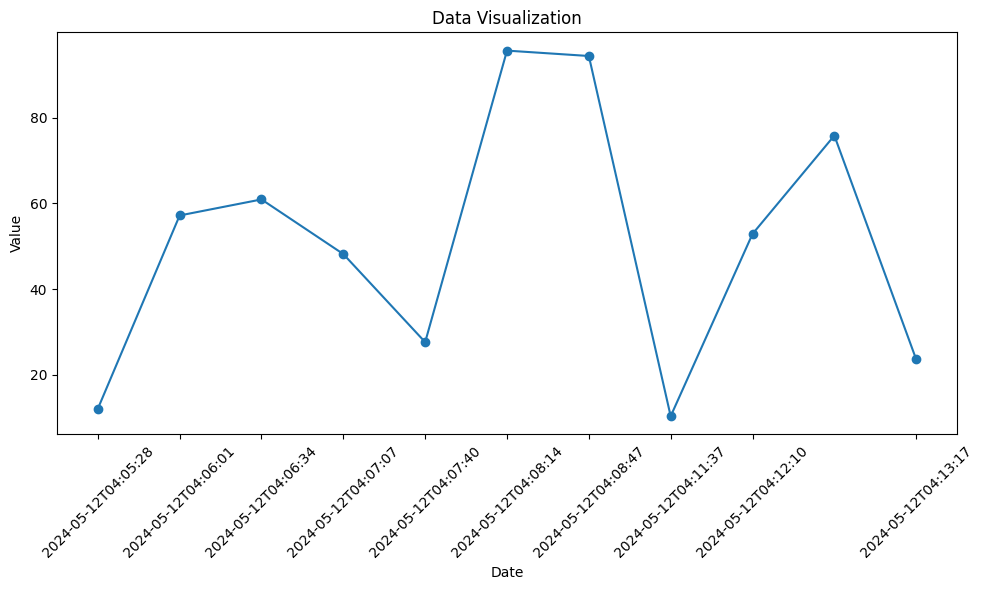

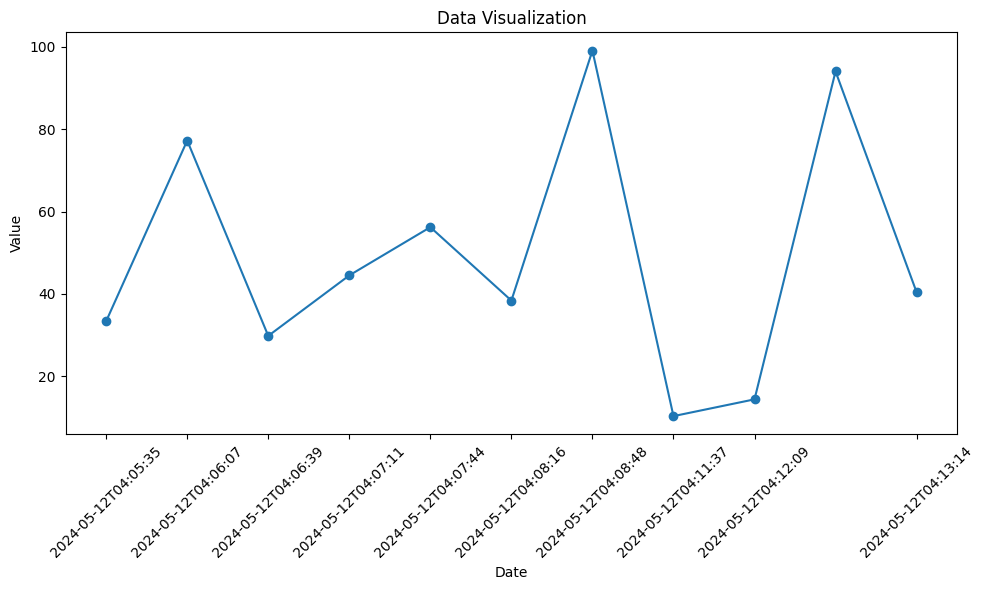

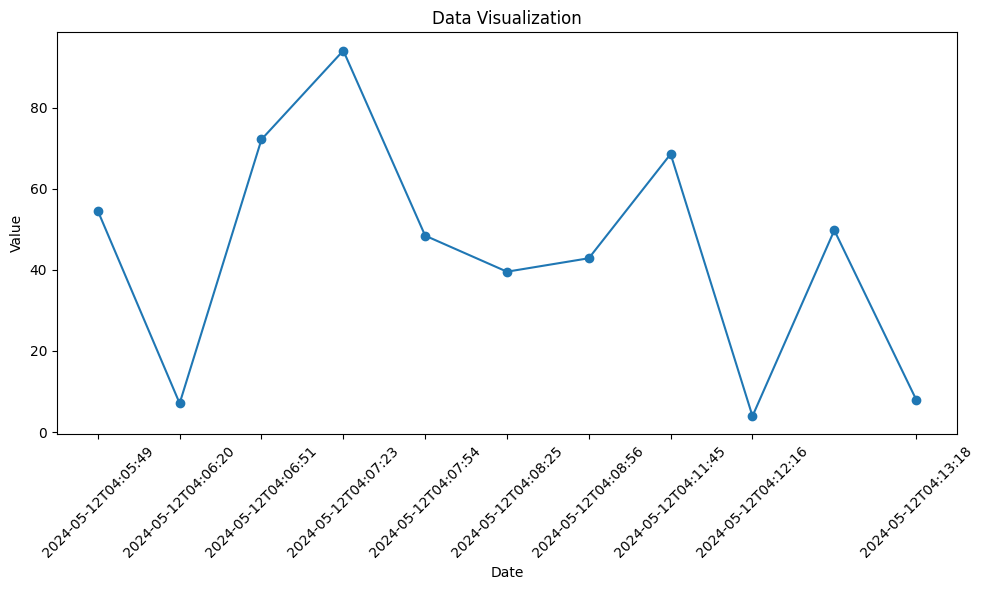

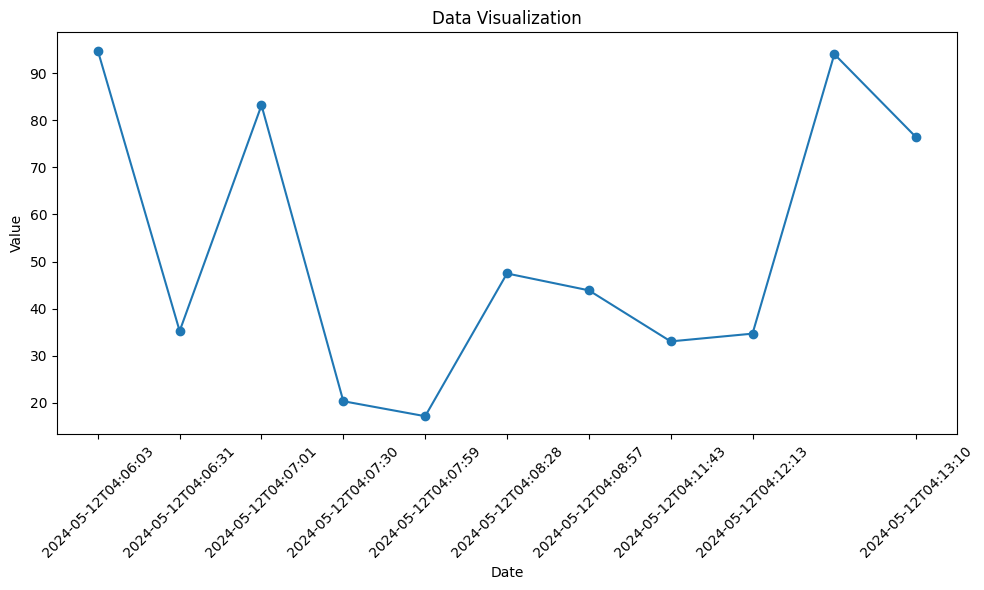

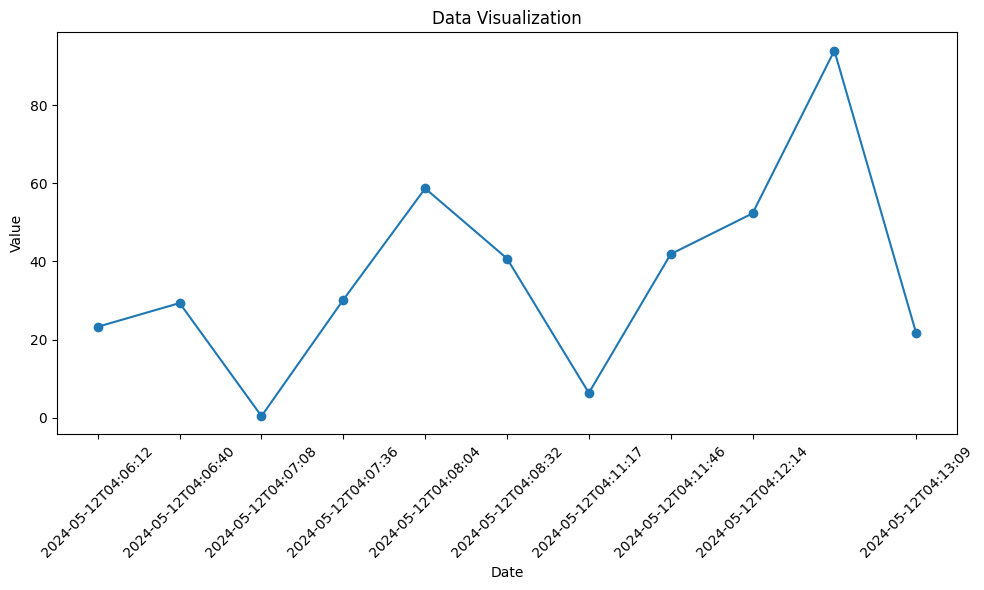

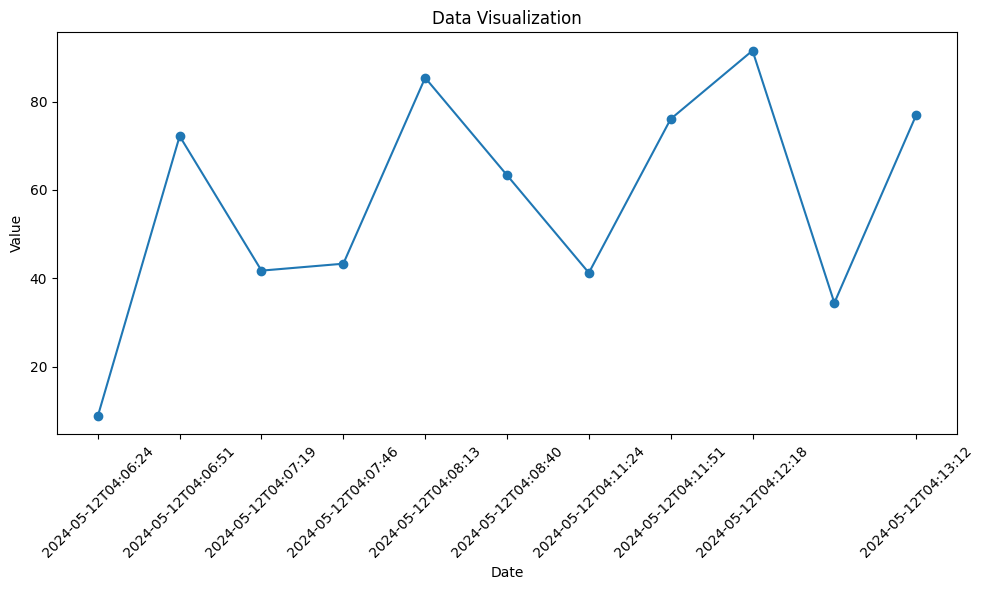

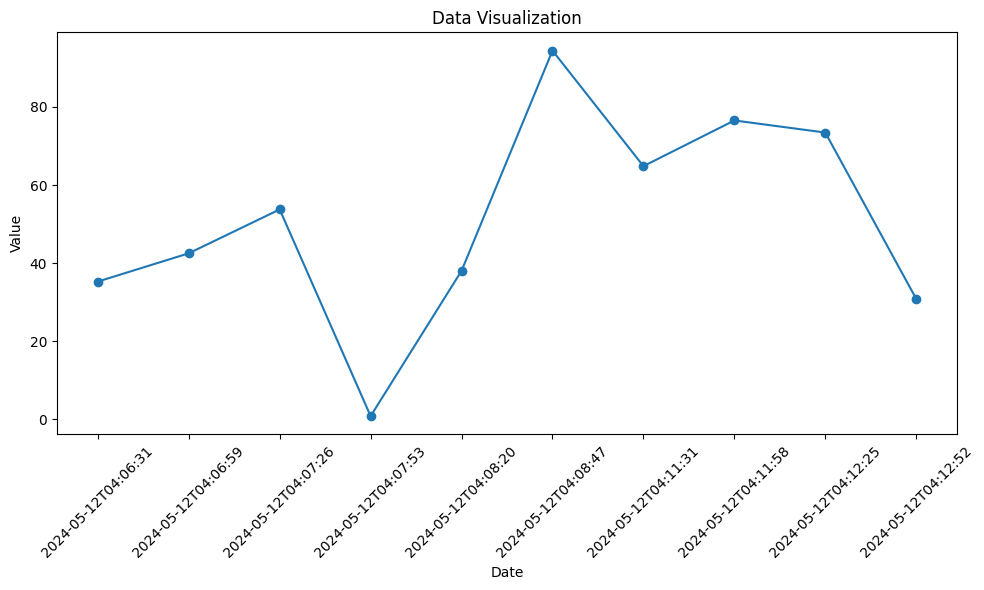

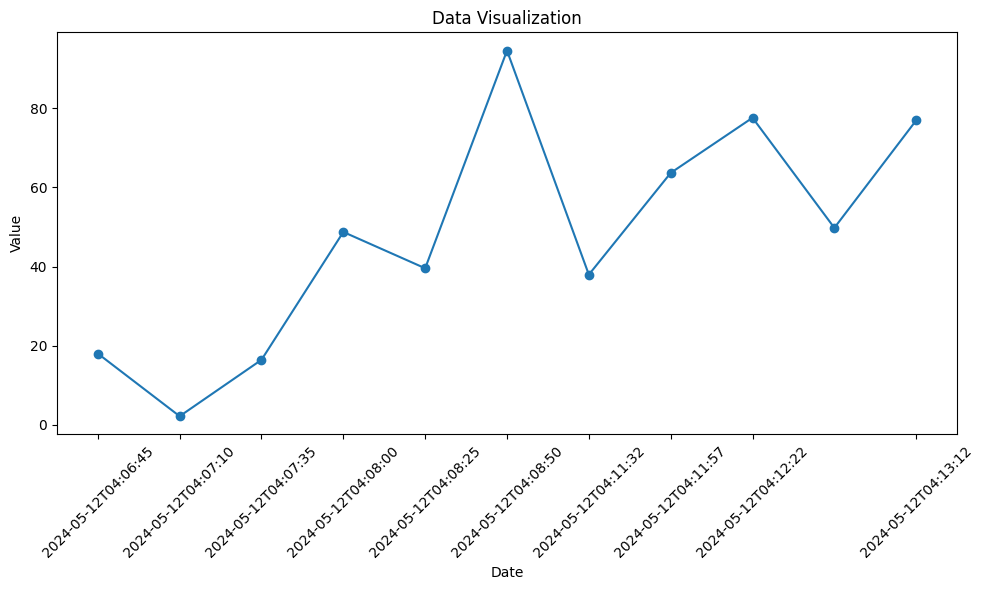

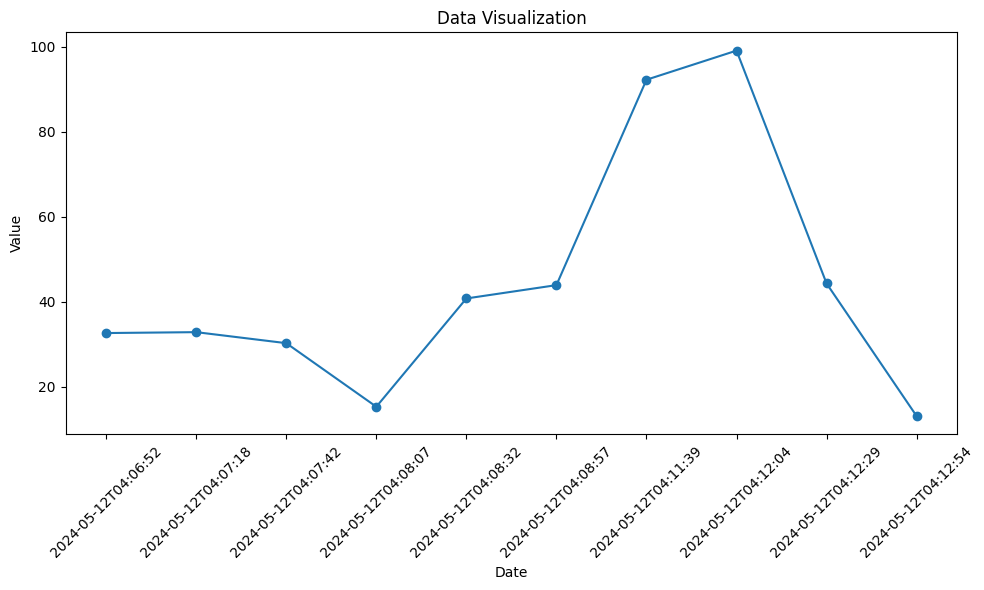

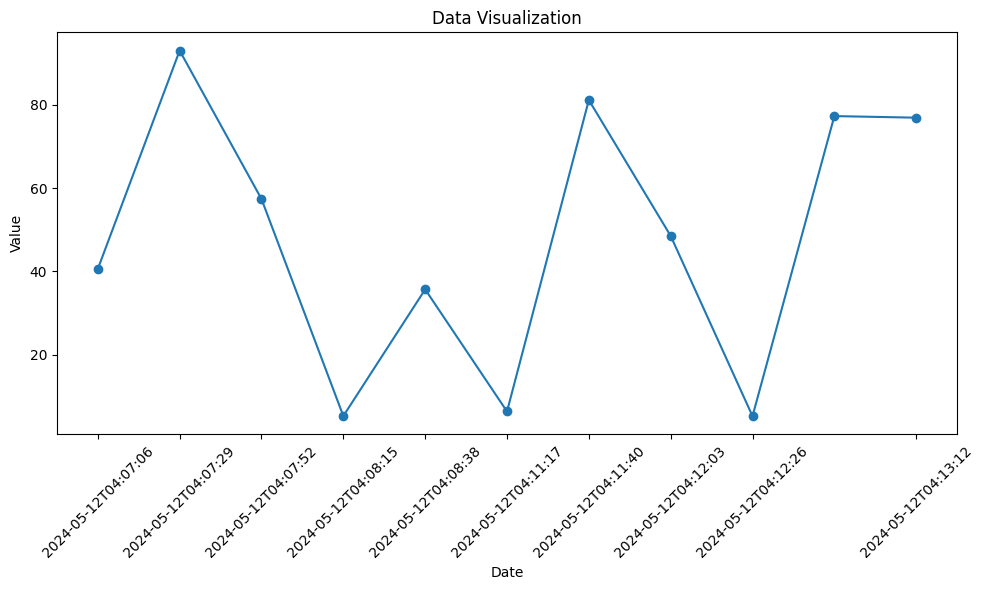

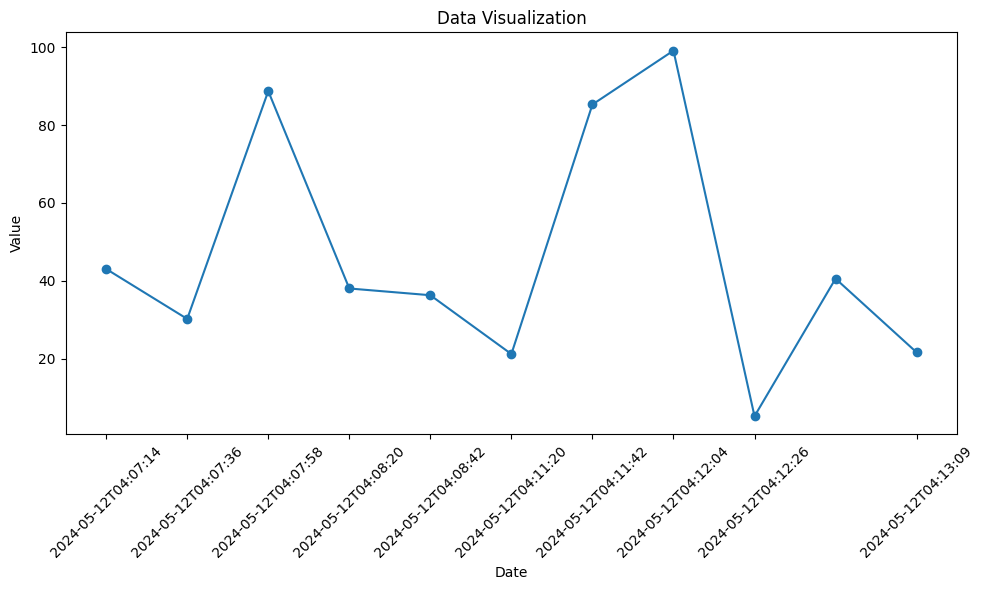

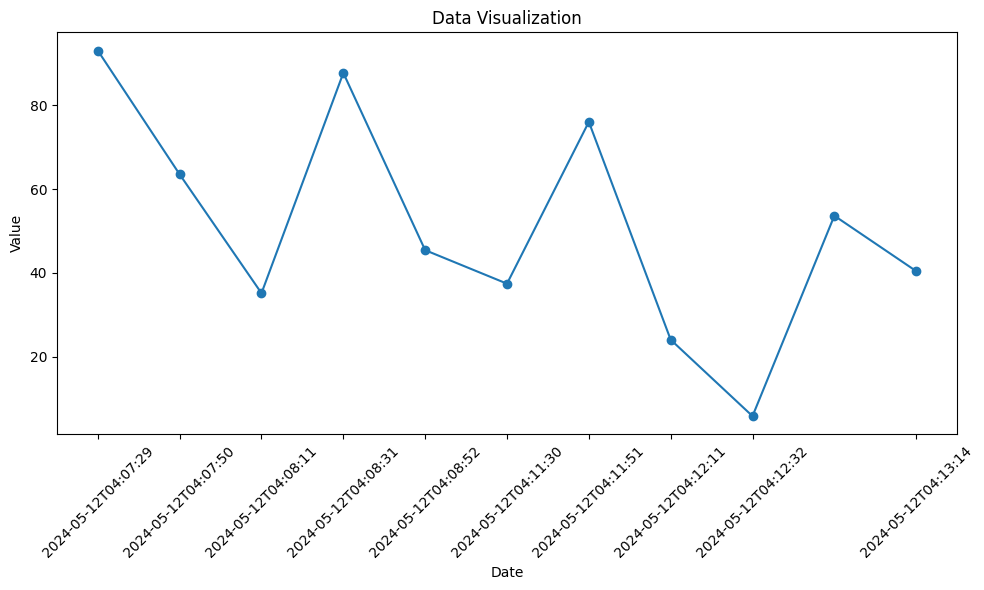

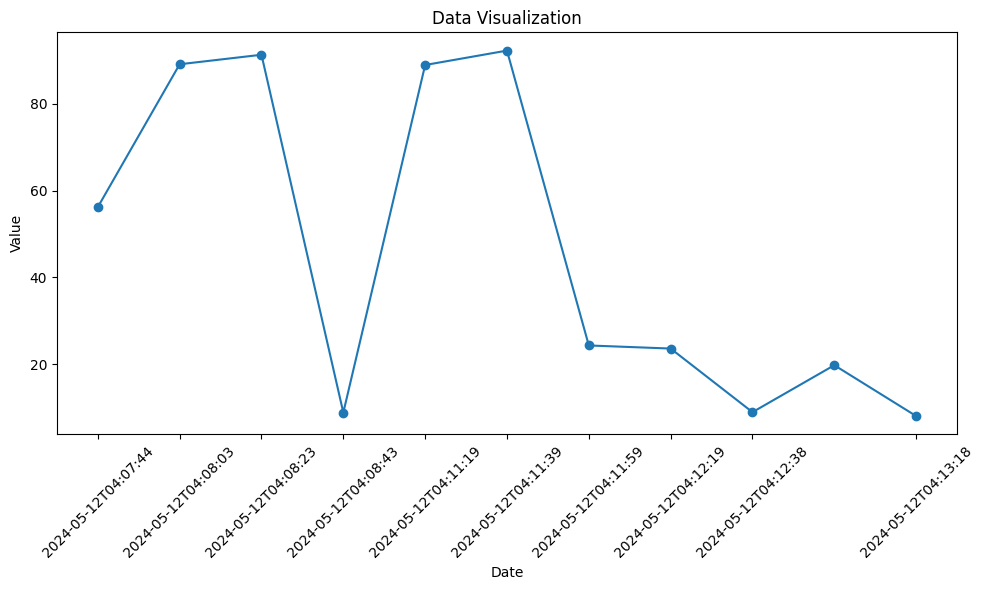

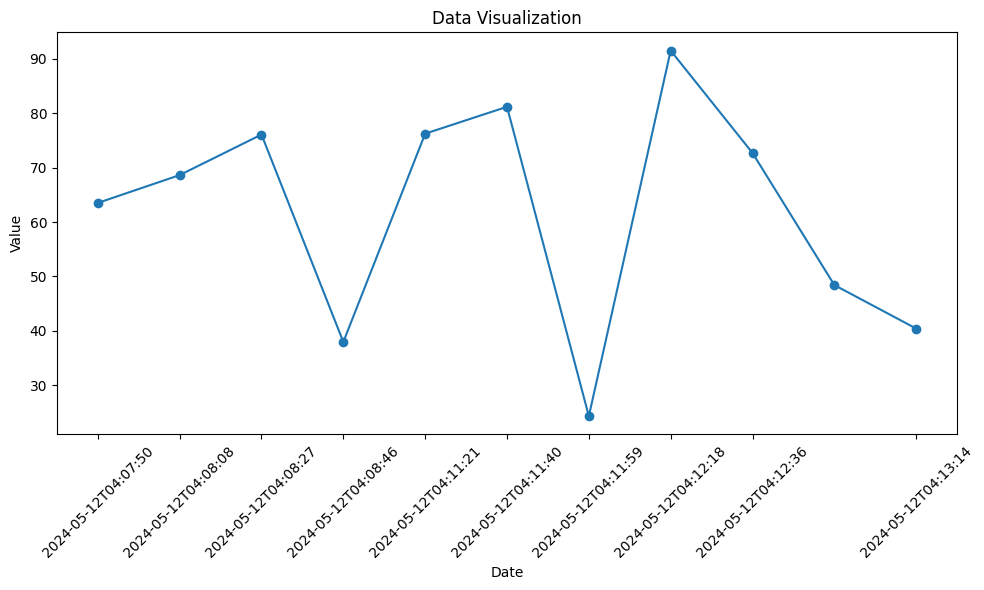

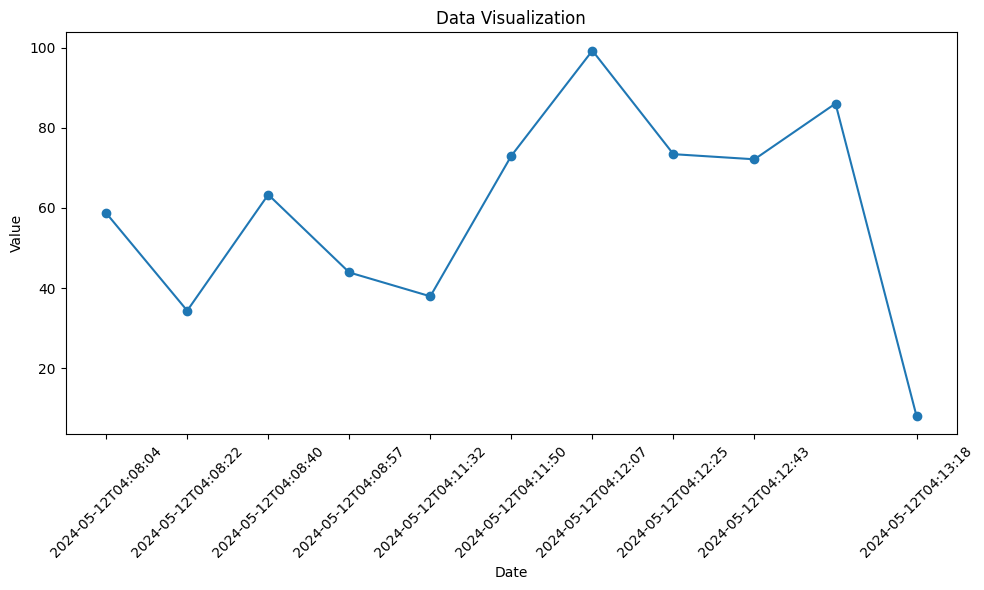

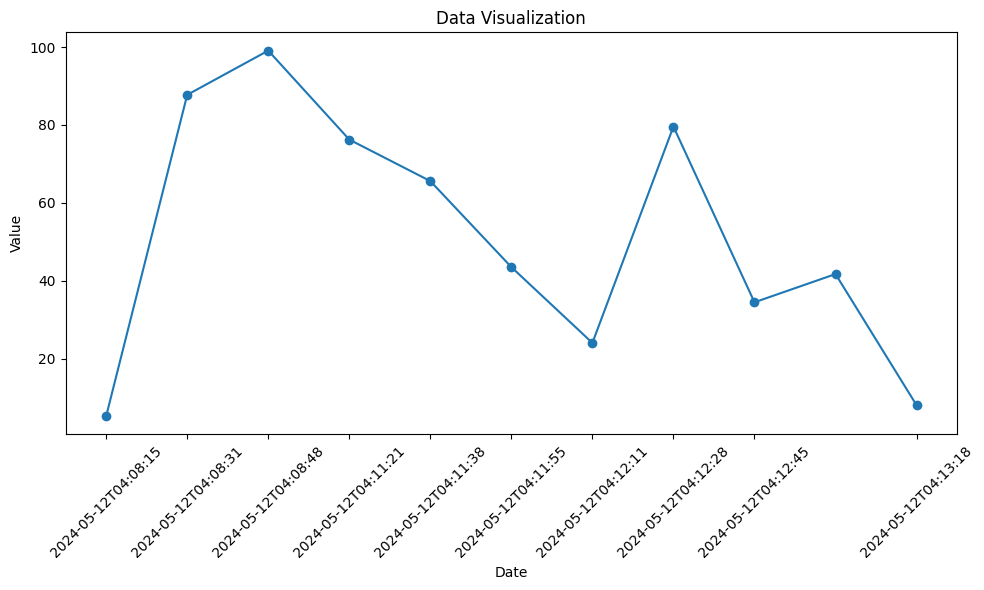

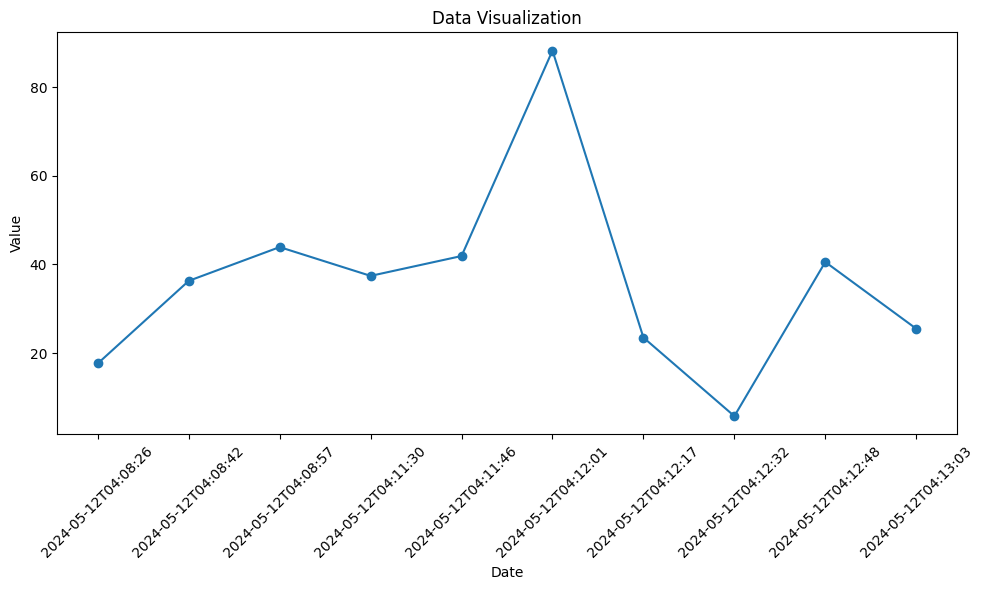

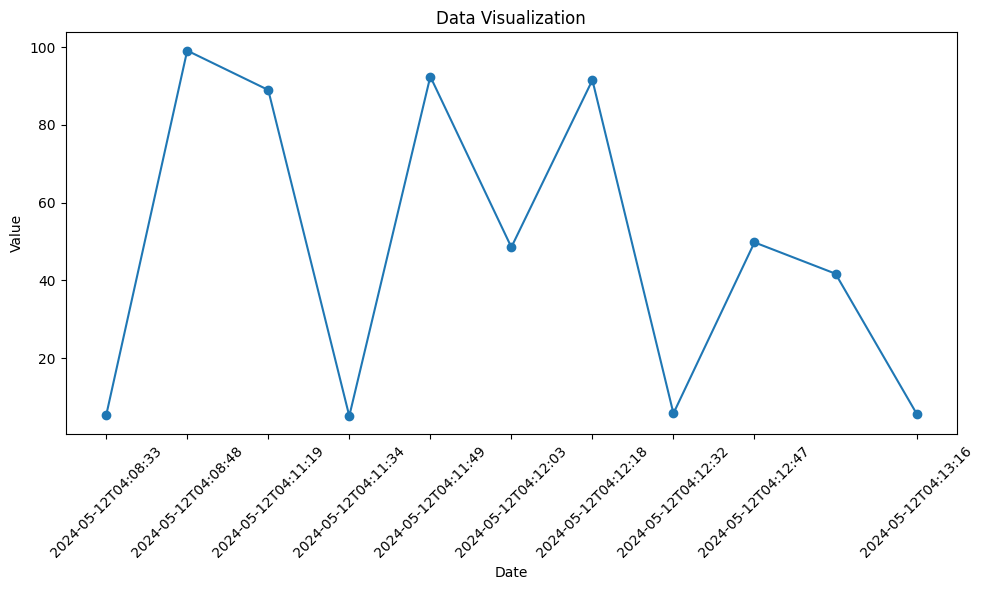

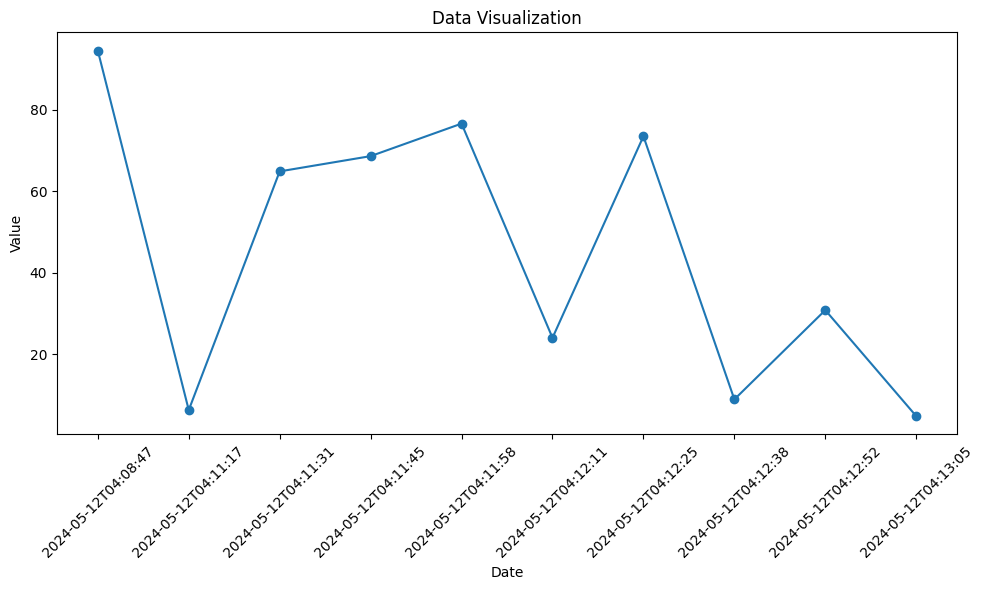

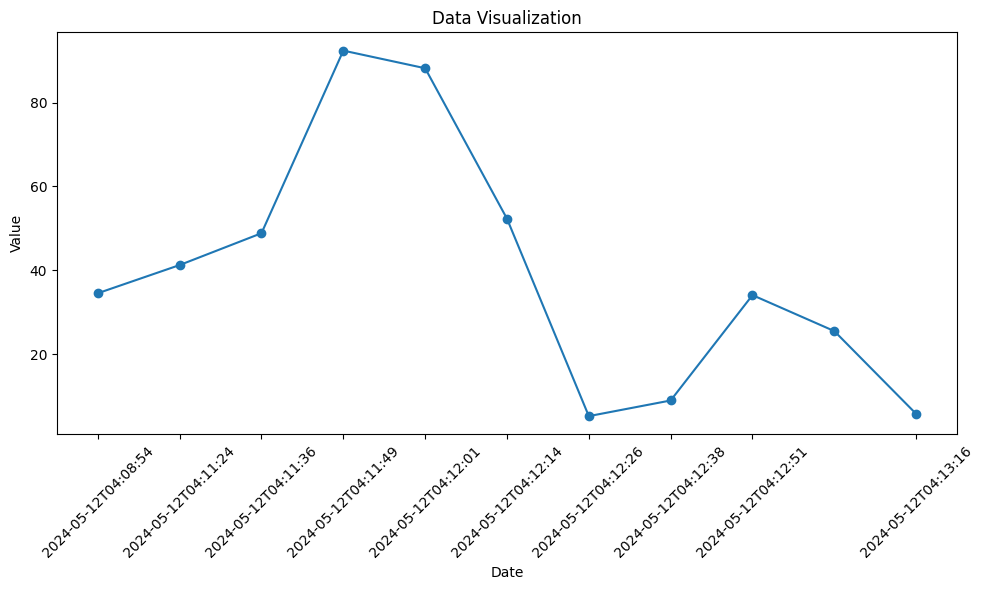

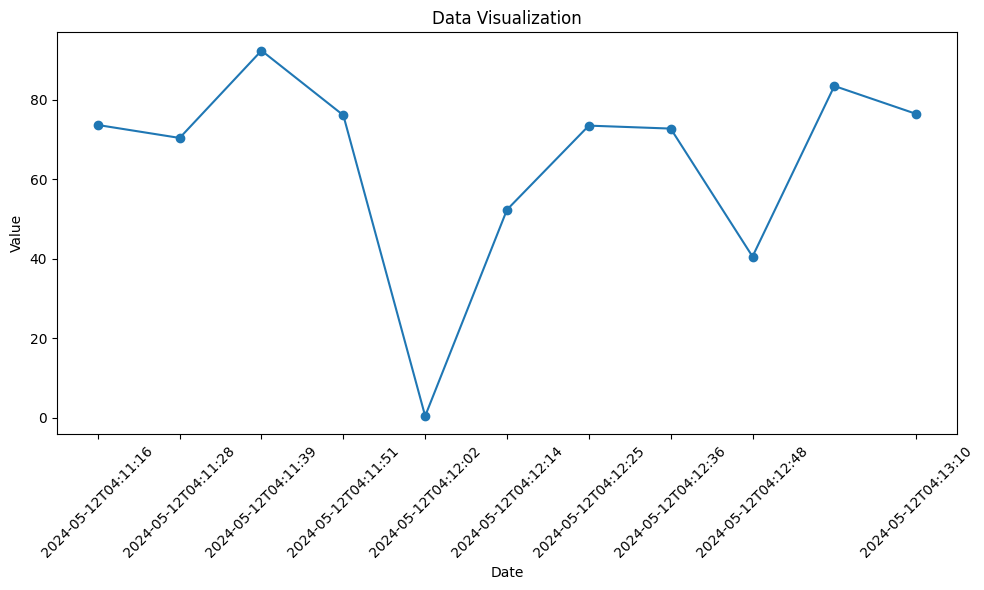

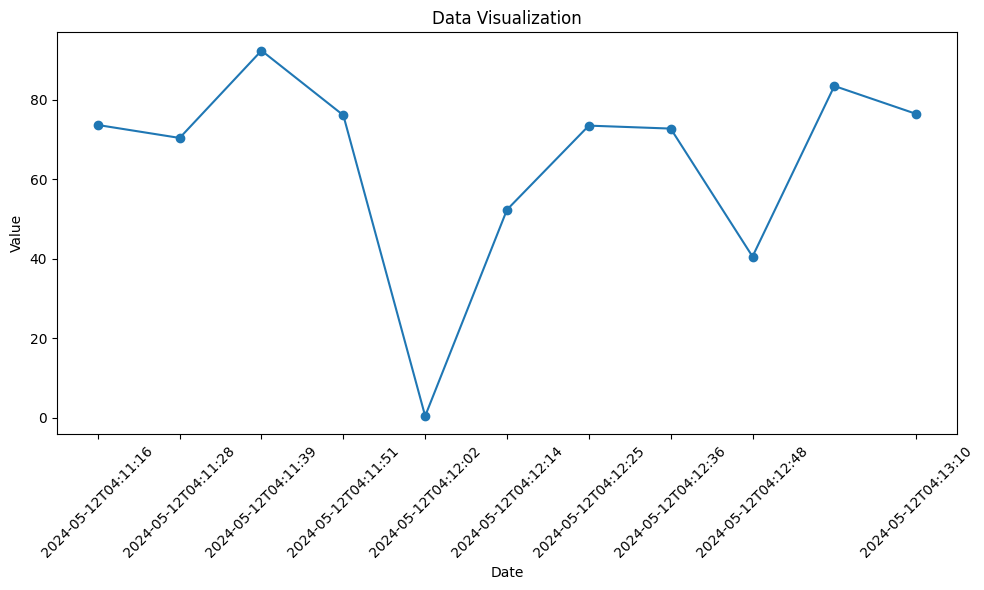

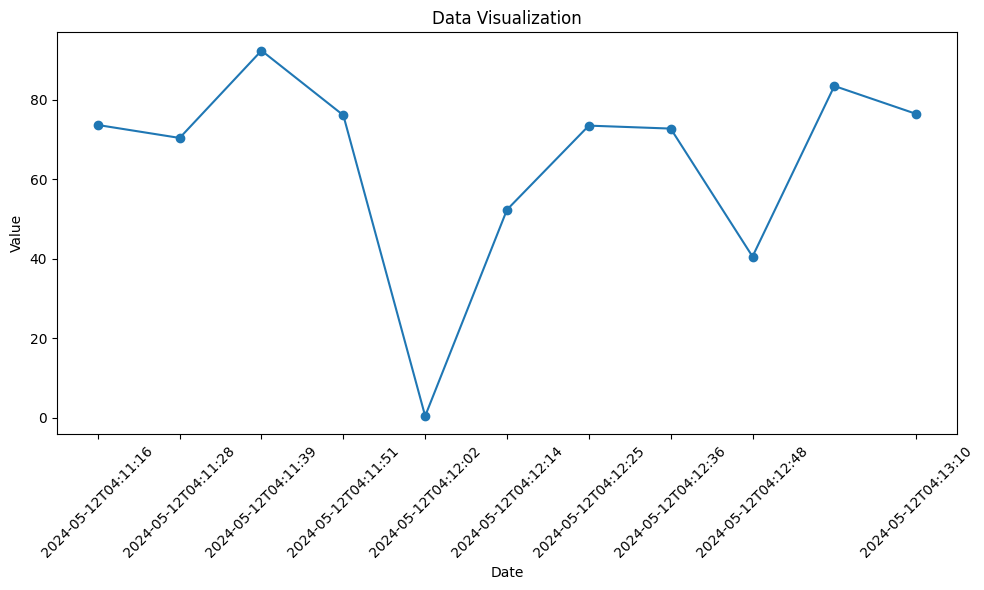

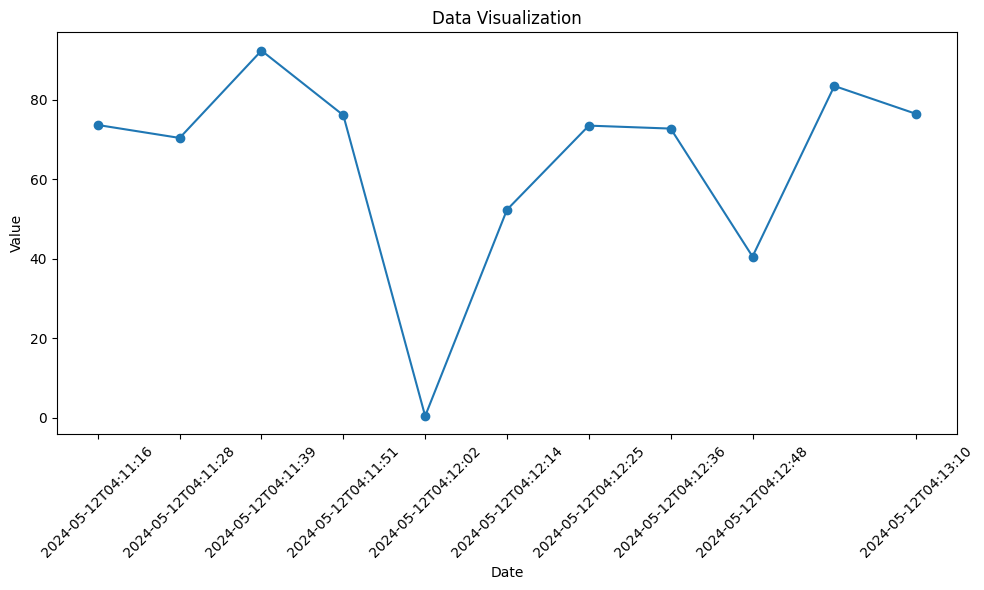

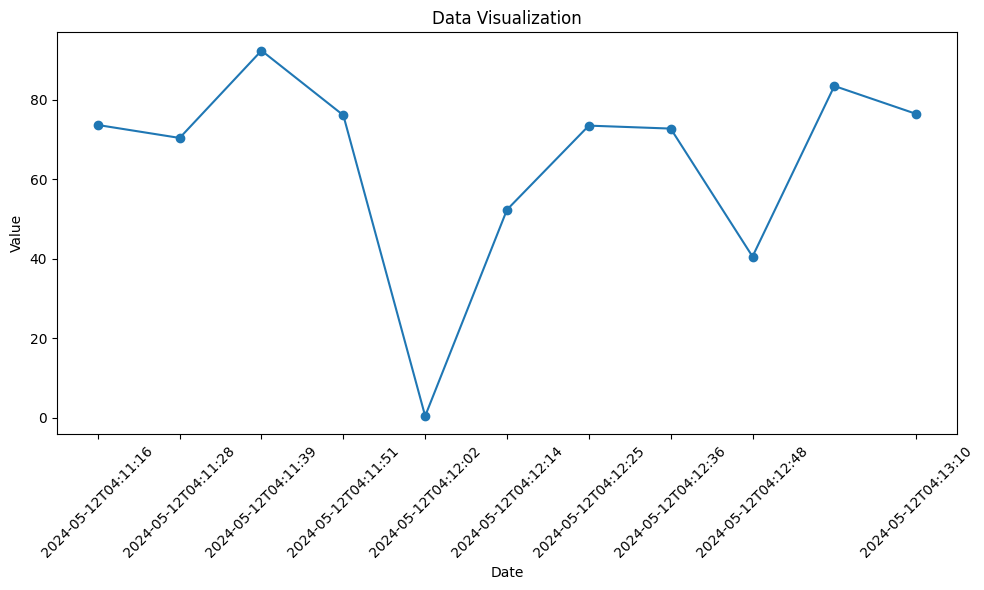

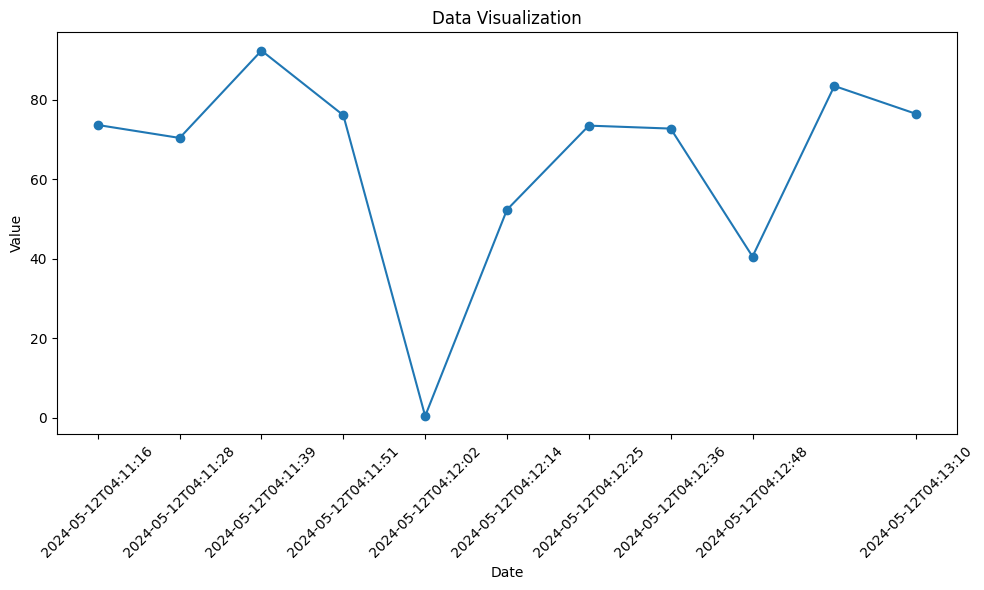

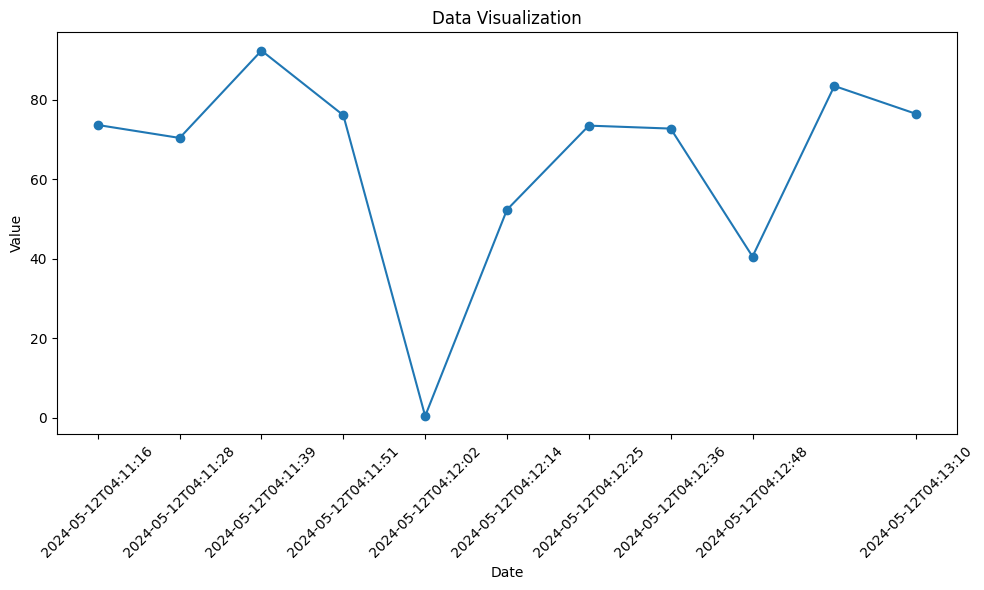

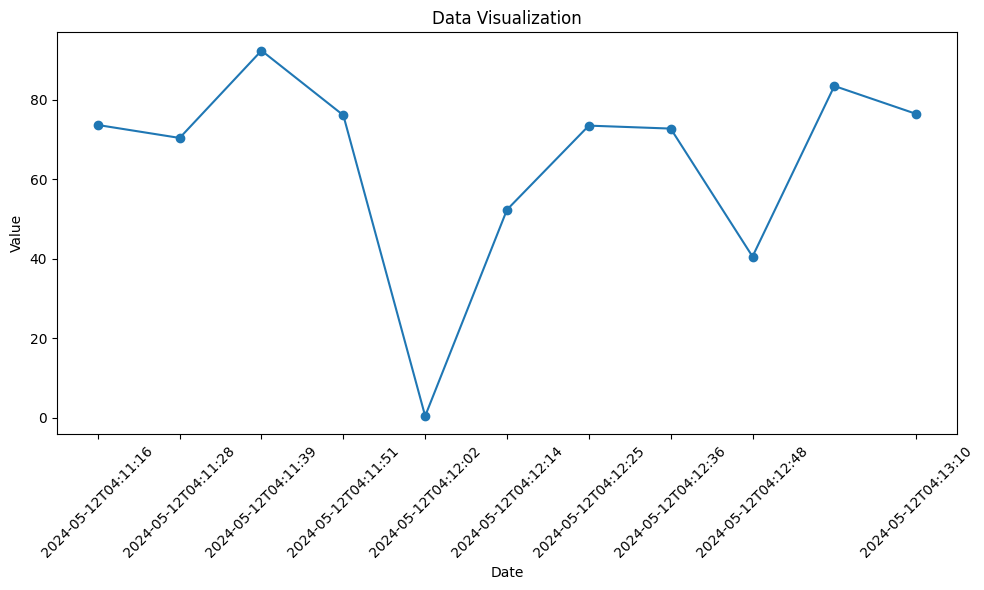

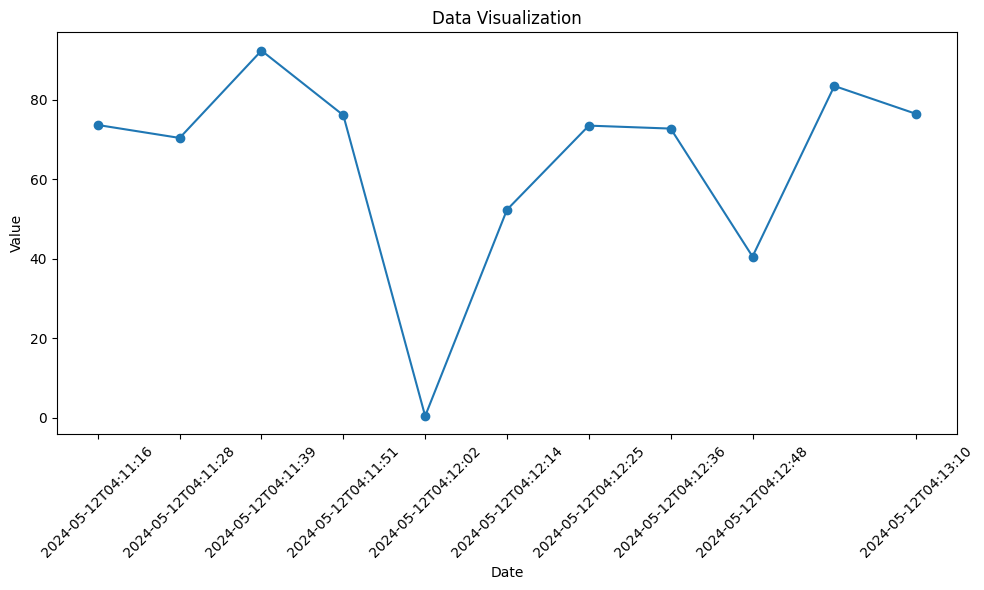

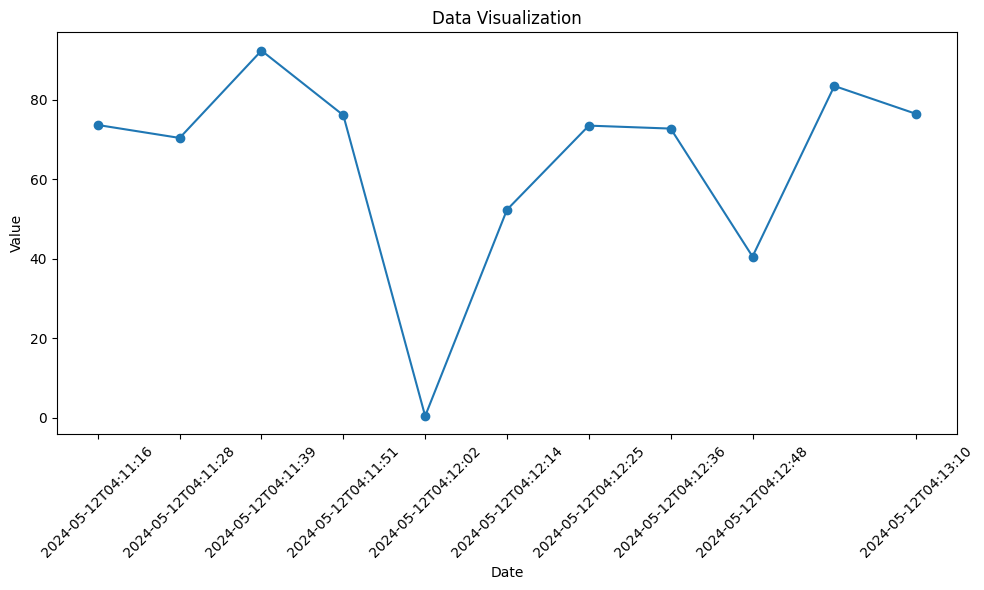

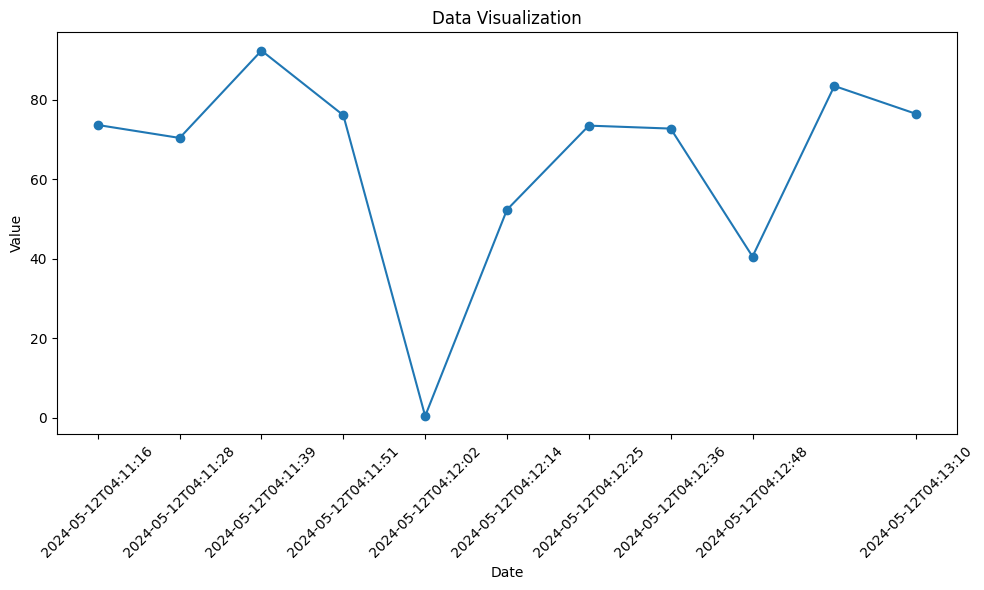

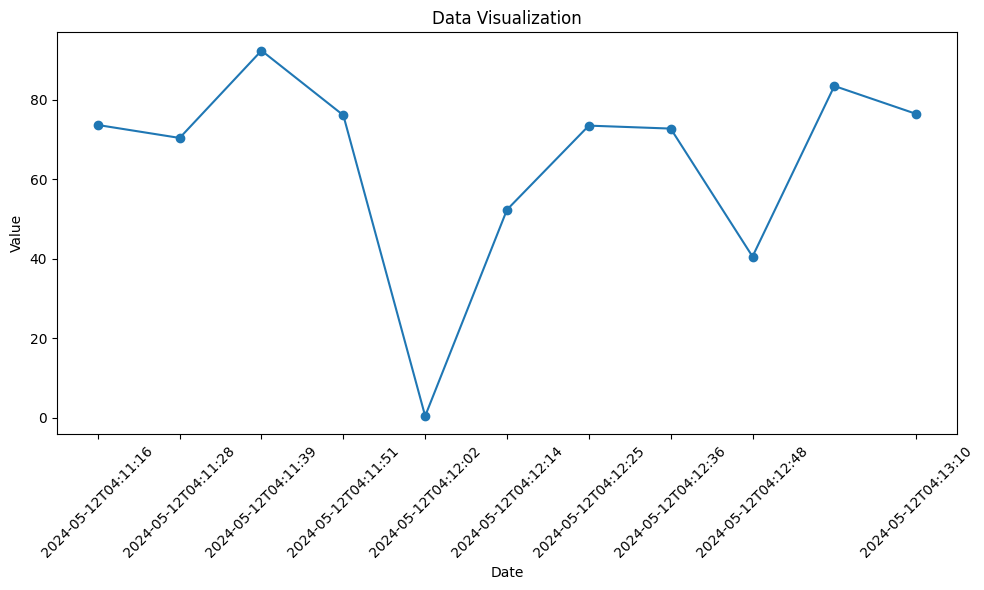

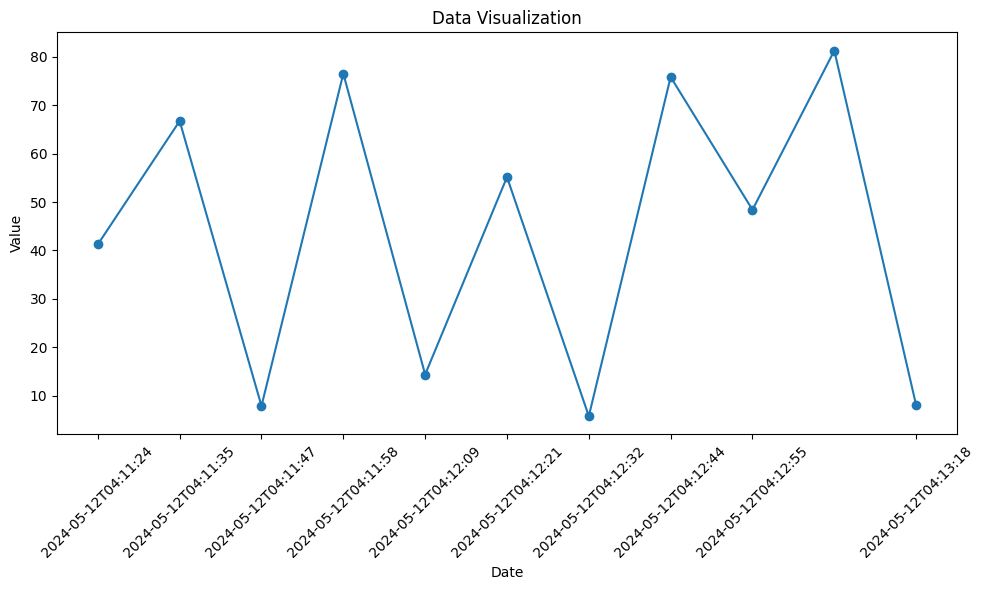

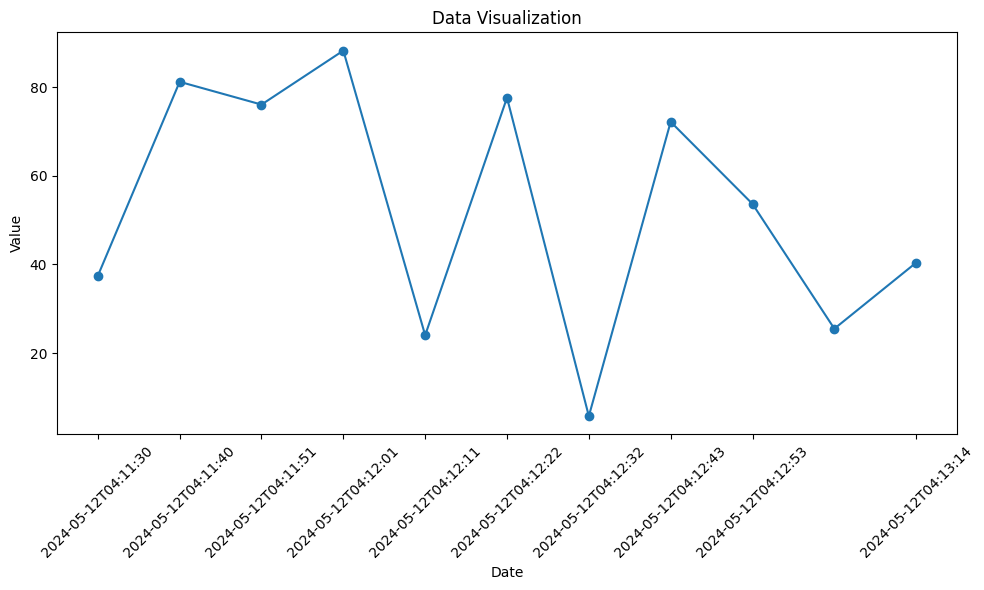

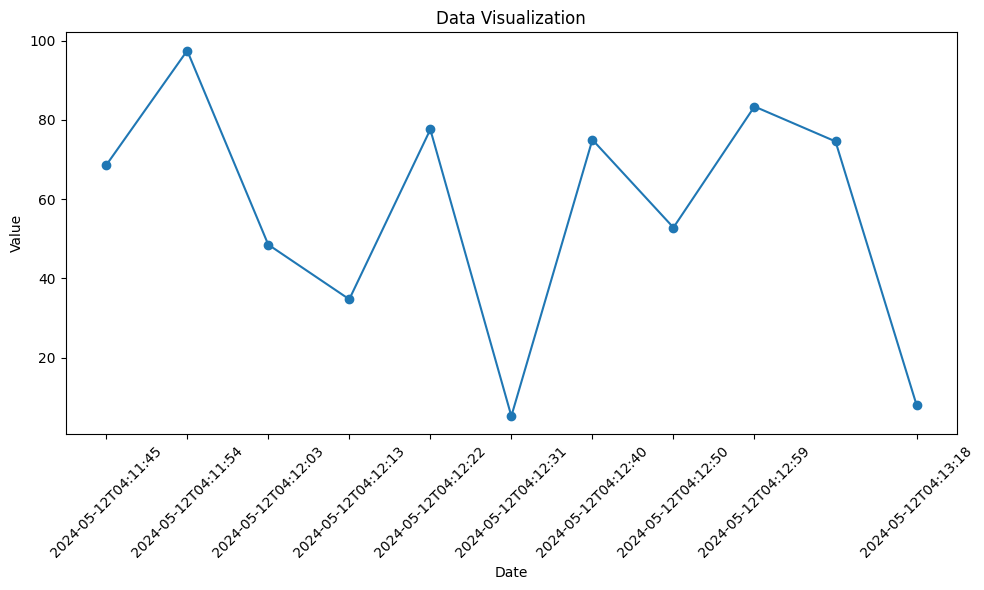

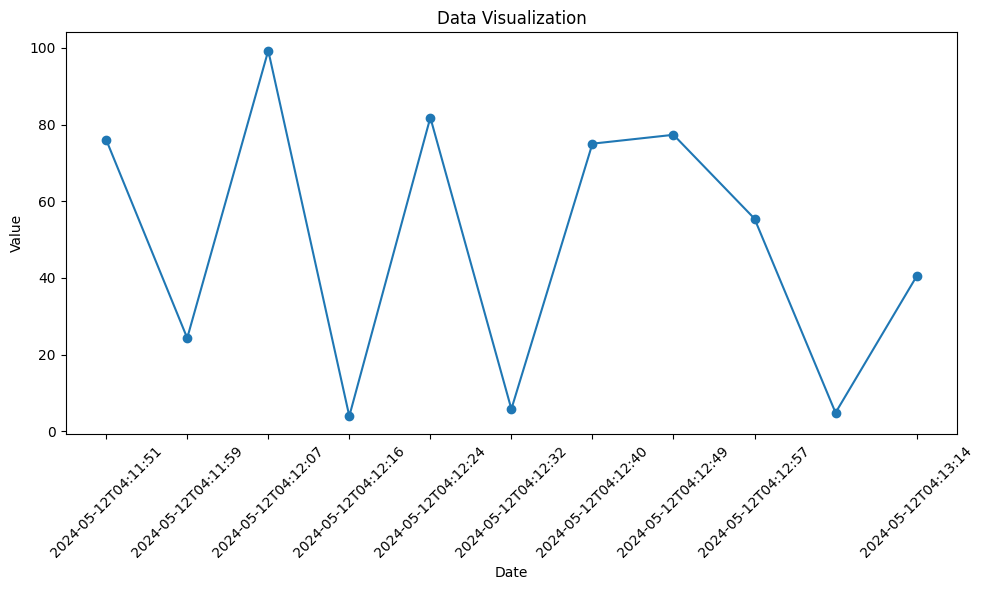

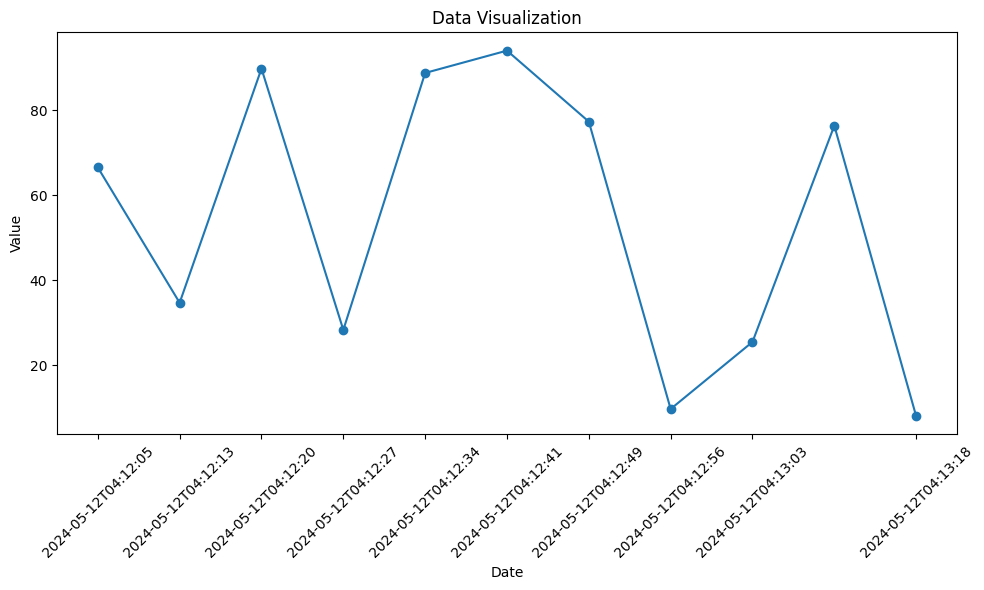

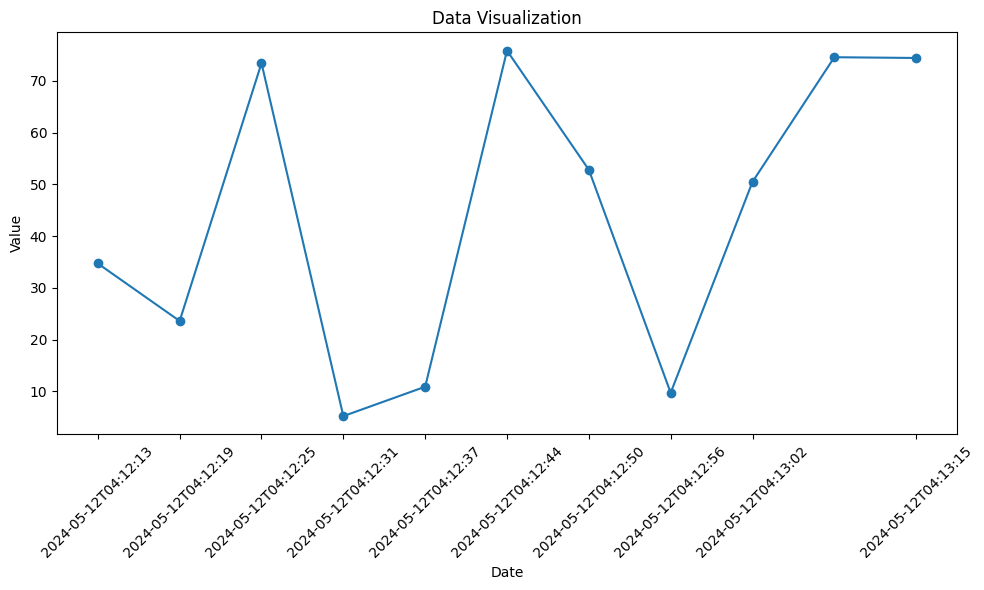

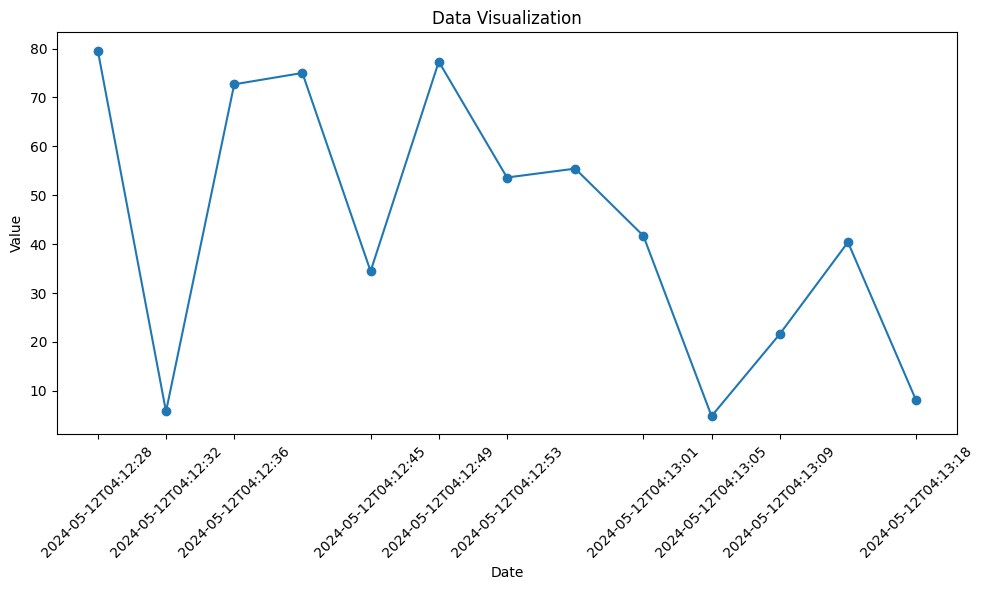

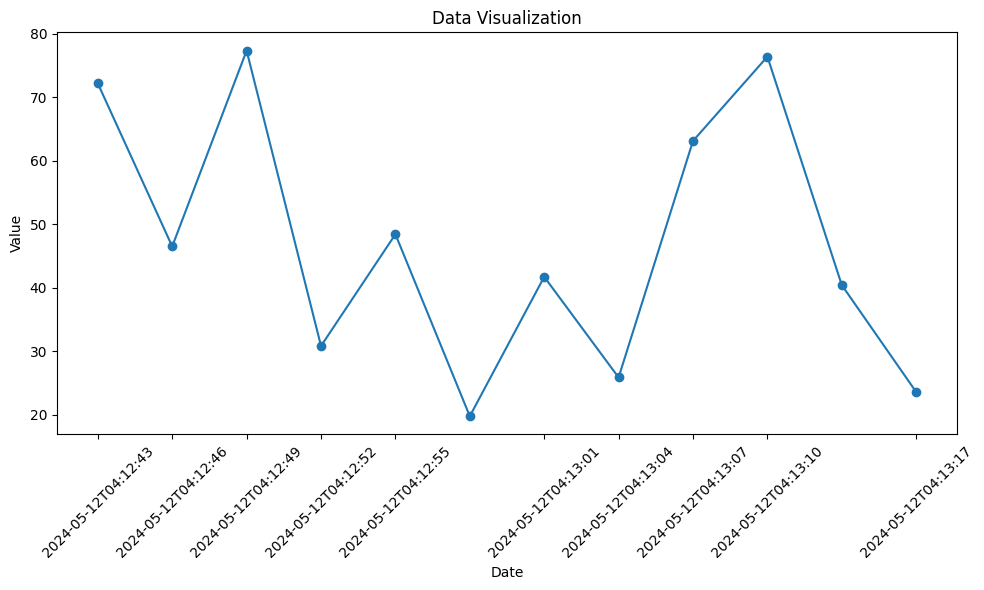

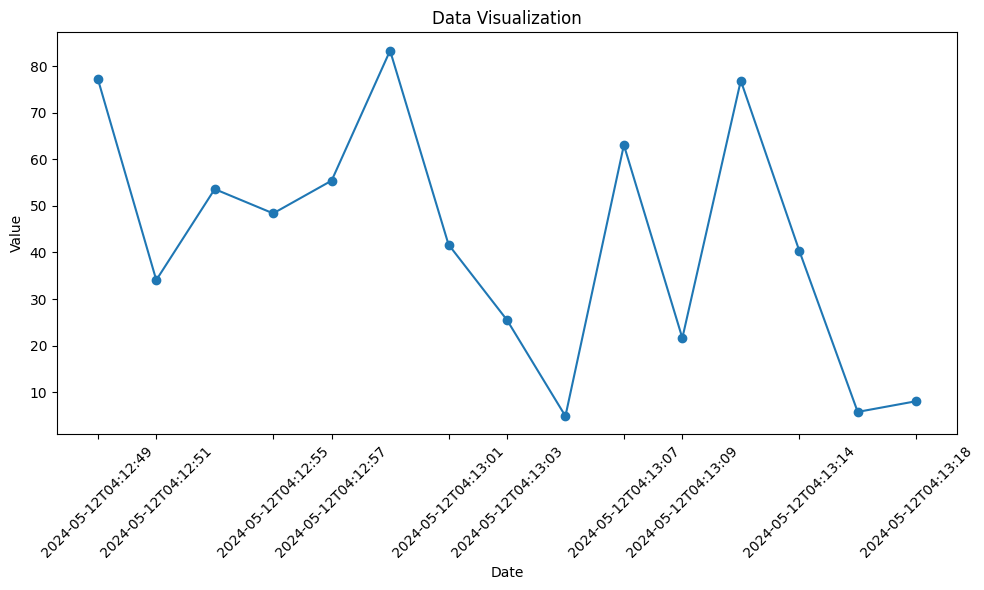

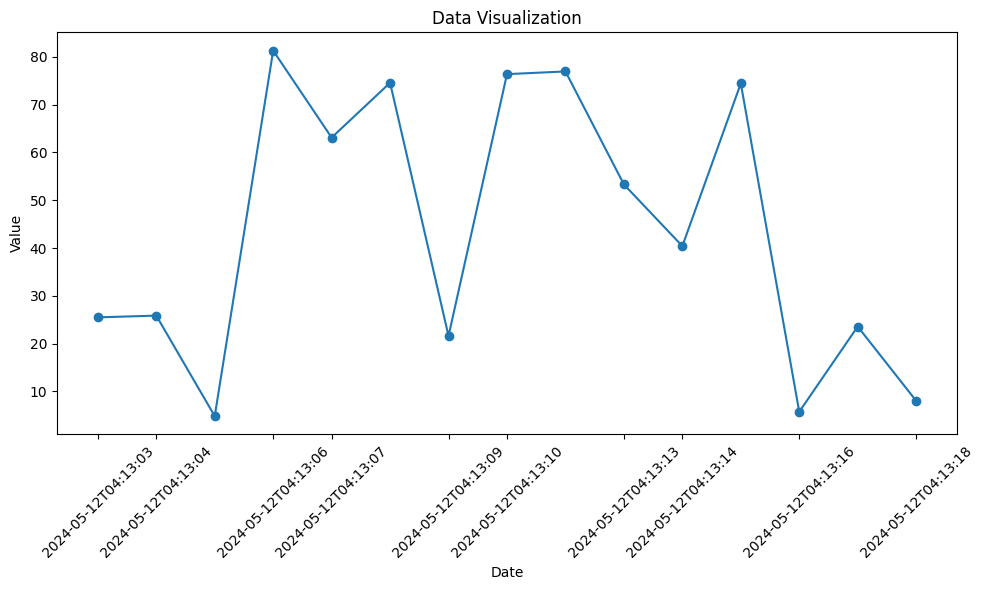

ValueError: slice step cannot be zero

In [1]:
import boto3
import json
import matplotlib.pyplot as plt
import time
import numpy as np

# Ensure Matplotlib plots display inline
%matplotlib inline

def download_latest_json_from_s3(bucket_name):
    """Download the latest JSON file from the S3 bucket."""
    s3 = boto3.client('s3', 
                     aws_access_key_id='XXXXXXXXXXXXXXXX', 
                      aws_secret_access_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    
    # List objects in the bucket
    response = s3.list_objects_v2(Bucket=bucket_name)
    

    # Extract the latest JSON file based on its last modified timestamp
    latest_file = None
    latest_timestamp = None
    for obj in response.get('Contents', []):
        key = obj['Key']
        if key.endswith('.json'):
            timestamp = obj['LastModified']
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_file = key
                latest_timestamp = timestamp
    
    # If a JSON file is found, download it
    if latest_file:
        response = s3.get_object(Bucket=bucket_name, Key=latest_file)
        json_content = response['Body'].read().decode('utf-8')
        json_data = json.loads(json_content)
        return json_data
    else:
        print("No JSON files found in the bucket.")
        return None

def visualize_data(json_data):
    """Visualize JSON data."""
    if not json_data:
        return
    
    # Assuming JSON data is in the format [{'date_time': '2024-05-11T17:36:19', 'other_field': 123}, ...]
    dates = [entry['date_time'] for entry in json_data]
    values = [entry['other_field'] for entry in json_data]

    # Downsample the datetime values to select only a subset
    n = len(dates) // 10  # Select approximately 10 datetime values
    dates_downsampled = dates[::n]
    values_downsampled = values[::n]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates_downsampled, values_downsampled, marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Data Visualization')
    
    # Set x-axis ticks to show only selected datetime values
    x_ticks_indices = np.linspace(0, len(dates_downsampled) - 1, num=10, dtype=int)
    plt.xticks(x_ticks_indices, [dates_downsampled[i] for i in x_ticks_indices], rotation=45)
    
    plt.tight_layout()
    plt.show()

def main():
    bucket_name = 'ddi-ggbucket-data'
    
    while True:
        # Download the latest JSON file from the S3 bucket
        json_data = download_latest_json_from_s3(bucket_name)
        
        # Visualize the data if JSON data is available
        if json_data:
            visualize_data(json_data)
        
        # Pause for a certain period before fetching the next JSON file
        time.sleep(10)  # Adjust the interval as needed

if __name__ == "__main__":
    main()